In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression,Ridge

import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.externals import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
def r2_score(y,y_hat):
    ratio = np.sum((y-y_hat)**2) / np.sum((y-np.mean(y))**2)
    r_square = 1 - ratio
    return r_square

In [3]:
# 讀取資料
data = pd.read_csv(r'C:\Users\GN1504301\Desktop\競賽資料-utf8\競賽資料-utf8\租屋資訊trainset.csv',encoding='utf-8')
test_set = pd.read_csv(r'C:\Users\GN1504301\Desktop\競賽資料-utf8\競賽資料-utf8\租屋資訊testset.csv',encoding='big5')

In [4]:
data['floor_ratio'] = data['floor'] / data['allfloor']
data['floor_ratio'].fillna(0,inplace = True)
data['cp_value'] = data['price'] / data['area']

data['walk_apart'] = 1
data['walk_apart'][data['floor'] > 6] = 0

data['first_floor'] = 0
data['first_floor'][data['floor'] == 0] = 1

data['region_cp_mean'] = data.groupby('sectionname')['cp_value'].transform('mean')
data['station_cp_mean'] = data.groupby('min_station_name')['cp_value'].transform('mean')

data['ground_space'] = 0
data['ground_space'][data['floor'] == 0] = 1

In [5]:
data['cp_value'].describe(percentiles = [.975,.985,.995])

count     10000.000000
mean       1486.085105
std        1951.417892
min         100.000000
50%        1400.000000
97.5%      2735.042735
98.5%      3000.000000
99.5%      3790.303693
max      185714.285714
Name: cp_value, dtype: float64

In [6]:
data['min_station_name'][data.address == '中山區天津街'] = '中山'
data['min_station'][data.address == '中山區天津街'] = 700
data['min_park'][data.address == '中山區天津街'] = 260

data['min_station_name'][data.address == '南港區林森路73巷'] = '南港展覽館'
data['min_station'][data.address == '南港區林森路73巷'] = 2300
data['min_park'][data.address == '南港區林森路73巷'] = 550

data['min_station_name'][data.address == '中山區中原街'] = '行天宮'
data['min_station'][data.address == '中山區中原街'] = 550
data['min_park'][data.address == '中山區中原街'] = 70

data['min_station_name'][data.address == '中山區中山二路42巷'] = '雙連'
data['min_station'][data.address == '中山區中山二路42巷'] = 400
data['min_park'][data.address == '中山區中山二路42巷'] = 290

In [7]:
test_list = test_set['min_station_name'].unique().tolist()
train_list = data['min_station_name'].unique().tolist()

[each for each in test_list if each not in train_list]

['淡水', '頂埔']

In [8]:
region_mean_frame = data[['sectionname','region_cp_mean']].drop_duplicates(subset = 'sectionname')

In [9]:
station_mean_frame = data[['min_station_name','station_cp_mean']].drop_duplicates(subset = 'min_station_name')

創造新變數

floor_ratio : 租屋的樓層比，值在0-1之間，想法是值越靠近1時租金會越便宜（爬越多樓梯？）<br>
cp_value : 每坪租金，用來做outlier值篩選 <br>
region_cp_mean : 同一行政區下的平均cp_value，用來衡量不同行政區的繁華程度 <br>
station_cp_mean : 同一捷運站下的平均cp_value，用來衡量不同捷運站的繁華程度(此變數較不穩定) <br>

In [10]:
def mapping(x):
    if x == '分租套房':
        return '1房0廳1衛'
    if x == '獨立套房':
        return '1房0廳1衛'
    if x == '雅房':
        return '1房0廳0衛'
    if x == '其他':
        return '0房0廳0衛'

In [11]:
data['layout2'] = data['kind_name'].apply(mapping)
data['layout_total'] = data['layout'].fillna('') + data['layout2'].fillna('')
data['rooms'] = data['layout_total'].str.split('房').str[0]
data['way'] = data['layout_total'].str.split('廳').str[1]
data['way'] = data['way'].str.split('衛').str[0]

data['rooms'][data.kind_name =='車位'] = 0
data['way'][data.kind_name =='車位'] = 0

創造新變數

rooms : 租屋房間數，假設其他類為0，套房類為1 <br>
way : 租屋衛浴數，假設其他與雅房類為0，套房類為1 <br>

In [12]:
data = data.query('room != 99').reset_index(drop = True)
data = data.query('cp_value < 4500').reset_index(drop = True) #7340 5001
data = data.query('floor_ratio <=1').reset_index(drop = True)
data = data.query('min_station <=12000').reset_index(drop = True)

移除資料

1. 99房 (開放式空間 + 車位) <br>
2. 極端cp_value <br>
3. floor_ratio > 1 <br>
4. min_station > 12000 <br>

In [13]:
def lux_tran(x):
    lux_list = ['豪華','裝潢','精緻','雅緻','全新','精美']
    n = 0
    for word in lux_list:
        if word in x:
            n += 1 
    if n > 0:
        return 1
    else:
        return 0
    
def up_tran(x):
    toproof = ['頂加','頂樓加蓋']
    n = 0
    for word in toproof:
        if word in x:
            n += 1
    if n > 0:
        return 1
    else:
        return 0

屋主對於房子的主觀感知: <br>
- 有裝潢 -> + <br>
- 頂加 -> - <br>

In [14]:
data['lux_dummy'] = data['fulladdress'].apply(lux_tran)
data['up_dummy'] = data['fulladdress'].apply(up_tran)

In [16]:
# 創造 kind_name & sectionname虛擬變數
kind_dum = pd.get_dummies(data.kind_name)
sect_dum = pd.get_dummies(data.sectionname)
dumms = pd.concat([kind_dum,sect_dum],axis = 1) 
data = pd.concat([data,dumms],axis = 1)

In [18]:
# 將living欄資訊轉為虛擬變數
living = pd.Series(data.living)
living.fillna('0',inplace=True)
liv_list = ['depart', 'advstore', 'market', 'night', 'park', 'school', 'hospital']

liv2_list = []
for i in living:
    liv_dict = OrderedDict()
    for j in i.split(','):
        '''
        if j not in liv_list:
            liv_list.append(j)
        '''
        if j in liv_list:
            liv_dict['%s' %j] = 1
    liv2_list.append(liv_dict)

liv_frame = pd.DataFrame(liv2_list)
liv_frame.fillna('0',inplace=True)

In [19]:
# 將condition欄資訊轉為虛擬變數
condition = pd.Series(data.condition)
condition.fillna('0',inplace=True)
cond_list = ['tv','icebox','cold','washer','hotwater','four','broadband','landpost','pet','cook','trabus','balcony_0',
 'lease','bed','wardrobe','sofa','bookTable','chair','balcony_1','naturalgas','cartplace','lift','boy','isleastrent',
 'girl','teaTable','bookshelf','dinette','watermemachine','gasstove','layout']

cond2_list = []
for i in condition:
    cond_dict = OrderedDict()
    for j in i.split(','):
        '''
        if j not in cond_list:
            cond_list.append(j)
        '''
        if j in cond_list:
            cond_dict['%s' %j] = 1
    cond2_list.append(cond_dict)

cond_frame = pd.DataFrame(cond2_list)
cond_frame.fillna('0',inplace=True)

In [20]:
dum_frame = pd.concat([liv_frame,cond_frame],axis = 1)
dum_frame.describe()

,depart,advstore,market,night,park,school,hospital,tv,icebox,cold,...,balcony_1,lift,boy,isleastrent,girl,teaTable,bookshelf,dinette,watermemachine,gasstove
count,9479,9479.0,9479.0,9479,9479.0,9479.0,9479,9479.0,9479.0,9479.0,...,9479.0,9479,9479,9479,9479,9479,9479,9479,9479,9479
unique,2,2.0,2.0,2,2.0,2.0,2,2.0,2.0,2.0,...,2.0,2,2,2,2,2,2,2,2,2
top,0,1.0,1.0,0,1.0,1.0,0,1.0,1.0,1.0,...,1.0,0,0,0,0,0,0,0,0,0
freq,5431,6318.0,5204.0,5698,6077.0,5856.0,4787,5846.0,6721.0,8371.0,...,6189.0,5519,9358,9414,8894,9476,9475,9478,9476,9478


從上面表格可看出有些變數呈現一面倒的狀況，例如dinette,gasstove,teaTable等等，這些變數的預測能力應該很糟糕

In [21]:
full = pd.concat([data,dum_frame],axis = 1)

In [22]:
# 刪除無用的欄位
col2drop = ['houseage','id','living','condition','address_img_title','lat','lng','loc_type','min_station_name','min_park_name',
            'unit','regionname','kind_name','fulladdress','layout','address','sectionname','room'
           ,'watermemachine','gasstove','dinette','teaTable','bookshelf','cp_value','layout2','layout_total'] #
cols = [col for col in full.columns if col not in col2drop]
full_data = full[cols]

In [23]:
full_data.head()

,area,price,floor,allfloor,min_station,min_park,floor_ratio,walk_apart,first_floor,region_cp_mean,...,sofa,bookTable,chair,naturalgas,cartplace,balcony_1,lift,boy,isleastrent,girl
0,15.0,16500.0,7,12,466.615329,128.302422,0.583333,0,0,1680.532380,...,1,1,1,0,0,0,0,0,0,0
1,6.0,7800.0,4,5,491.912541,203.220846,0.800000,1,0,1326.795479,...,0,1,1,0,0,0,0,0,0,0
2,45.0,45000.0,10,14,1299.338389,99.717441,0.714286,0,0,1279.257306,...,1,1,1,1,1,1,0,0,0,0
3,9.0,18000.0,14,15,523.118458,183.753753,0.933333,0,0,1680.532380,...,1,1,1,0,0,0,0,0,0,0
4,15.1,16000.0,5,10,150.628808,211.178627,0.500000,1,0,1537.655015,...,1,1,1,1,1,1,1,0,0,0


In [24]:
full_data_y = np.ravel(full_data.price)
full_data_x = full_data.drop(['price'],axis = 1)

有60個x,其中大多是dummy variable

In [25]:
train_ratio = 0.99
idx = int(full_data.shape[0]*train_ratio)
train_data = full_data[:idx]
test_data = full_data[idx:]

In [26]:
train_y = np.ravel(train_data.price)
train_x = train_data.drop(['price'],axis = 1)

test_y = np.ravel(test_data.price)
test_x = test_data.drop(['price'],axis = 1)

將資料分成training & testing

In [27]:
train_x.columns

Index(['area', 'floor', 'allfloor', 'min_station', 'min_park', 'floor_ratio',
       'walk_apart', 'first_floor', 'region_cp_mean', 'station_cp_mean',
       'ground_space', 'rooms', 'way', 'lux_dummy', 'up_dummy', '其他', '分租套房',
       '整層住家', '獨立套房', '車位', '雅房', '中山區', '中正區', '信義區', '內湖區', '北投區', '南港區',
       '士林區', '大同區', '大安區', '文山區', '松山區', '萬華區', 'depart', 'advstore',
       'market', 'night', 'park', 'school', 'hospital', 'tv', 'icebox', 'cold',
       'washer', 'hotwater', 'four', 'broadband', 'landpost', 'pet', 'cook',
       'trabus', 'balcony_0', 'lease', 'bed', 'wardrobe', 'sofa', 'bookTable',
       'chair', 'naturalgas', 'cartplace', 'balcony_1', 'lift', 'boy',
       'isleastrent', 'girl'],
      dtype='object')

In [28]:
clf = GradientBoostingRegressor(loss='ls', alpha=0.95,
                            n_estimators=1000, max_depth=8,
                            learning_rate=.1, min_samples_leaf=8,
                            min_samples_split=15,subsample = 0.8)

clf.fit(train_x, train_y)
print('train:',r2_score(train_y,clf.predict(train_x)))
print('test:',r2_score(test_y,clf.predict(test_x)))

train: 0.999816612888
test: 0.980458204081


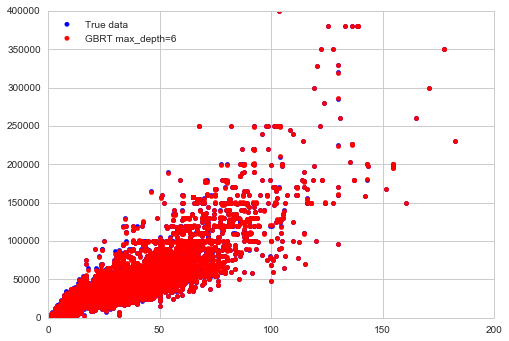

In [29]:
plt.scatter(full_data['area'], full_data['price'], color='b', label='True data')
plt.scatter(train_x['area'], clf.predict(train_x), color='r', label='GBRT max_depth=6')
plt.xlim([0,200])
plt.ylim([0,400000])
plt.legend(loc='upper left')

In [197]:
joblib.dump(clf, 'clf.pkl')

In [30]:
scores = cross_val_score(clf, train_x, train_y, cv=5, scoring='r2')
scores

array([ 0.84536313,  0.91395804,  0.88763279,  0.92445845,  0.90803509])

In [31]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
tree_columns = train_x.columns

# Print the feature ranking
print("Feature ranking:")

rf_list = []
for f in range(train_x.shape[1]):
    rf_dict = {}
    #print("%d. feature %d : %s (%f)" % (f + 1,indices[f], tree_columns[indices[f]],importances[indices[f]]))
    rf_dict['feature'] = tree_columns[indices[f]]
    rf_dict['importances'] = importances[indices[f]]
    rf_list.append(rf_dict)

importance_frame = pd.DataFrame(rf_list)
importance_frame_10 = importance_frame[0:10]
importance_frame

Feature ranking:


,feature,importances
0,area,2.200517e-01
1,min_park,1.096397e-01
2,min_station,1.062363e-01
3,floor_ratio,8.505965e-02
4,station_cp_mean,5.725037e-02
5,allfloor,5.186093e-02
6,floor,4.055106e-02
7,rooms,2.606174e-02
8,region_cp_mean,2.162388e-02
9,way,1.521396e-02


[<matplotlib.text.Text at 0xd61edd8>, <matplotlib.text.Text at 0x10761588>]

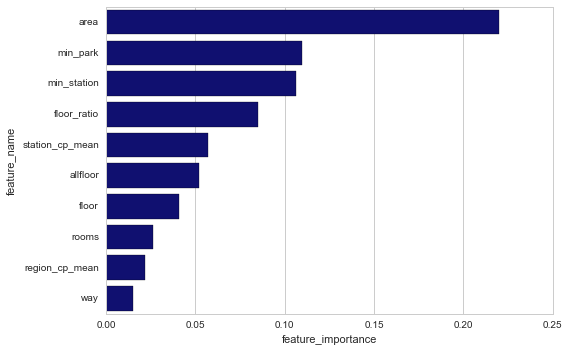

In [32]:
ax = sns.barplot(y =importance_frame_10['feature'] ,x =importance_frame_10['importances'],color = 'navy')
ax.set(xlabel = 'feature_importance',ylabel = 'feature_name')

In [68]:
test_set[test_set.min_station_name == '頂溪']

,id,room,area,houseage,living,condition,floor,layout,allfloor,kind_name,...,address_img_title,unit,address,lat,lng,loc_type,min_station,min_station_name,min_park,min_park_name
587,4674628,0,5.0,0,NaN,"icebox,washer,hotwater,four,broadband,naturalg...",13,NaN,14,雅房,...,•新大樓，好美雅房、淋浴雅房，青年公園,元/月,萬華區青年路152巷,25.020467,121.501596,GEOMETRIC_CENTER,1580.464947,頂溪,443.504239,壽德公園
3023,4712332,3,30.0,0,NaN,"cold,hotwater,landpost,cook,balcony_1,wardrobe...",4,3房2廳1衛,5,整層住家,...,近果菜市場（華中橋）公車站牌青年公園,元/月,萬華區萬大路493巷48弄16號,25.019310,121.499130,ROOFTOP,1755.733908,頂溪,422.052809,保德公園
4377,4742567,2,23.0,0,"advstore,market,park,school","cold,washer,hotwater,landpost,cook,balcony_1,bed",4,2房2廳1衛,5,整層住家,...,"採光佳,生活機能佳,近市場",元/月,萬華區富民路145巷,25.018594,121.500570,GEOMETRIC_CENTER,1592.114797,頂溪,562.084227,保德公園


疑? 怎麼會有新北市的捷運站跑出來 <br>
原來是萬華區靠近新店溪的房子= = http://ppt.cc/un5jY <br>
台北市靠近環河的房子都會有相同的問題 <br>
就是離捷運站直線距離很短，但是實際走路的距離很長，這幾個例子來說大概差了1km左右 <br>
目前想到的解決方法是用Googlemap Distance Matrix 算出實際行走距離

In [70]:
data[(data.min_station_name == '頂埔')]

,id,room,area,price,houseage,living,condition,floor,layout,allfloor,...,address_img_title,unit,address,lat,lng,loc_type,min_station,min_station_name,min_park,min_park_name
375,4796611,0,8.0,10000.0,0,NaN,"icebox,cold,washer,hotwater,broadband,naturalg...",2,NaN,20,...,包水電網路-近中研院大套房出租,元/月,南港區林森路73巷,22.592557,120.331478,ROOFTOP,285948.679606,頂埔,293537.831475,樟新公園


當然也有錯得很離譜的資料 http://ppt.cc/YxJaf <br>
重點是test_set裡面也有發生 = = <br>
這種就....用南港展覽館取代吧?!